# Grover's Search Algorithm

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

t = Tracker().start()

In this tutorial, we provide a step-by-step walkthrough explaining Grover's quantum algorithm. We show how to build the corresponding quantum circuit with simple modular building blocks using the Braket SDK. Specifically, we demonstrate how to build custom gates that are not part of the basic gate set provided by the SDK. A custom gate can used as a core quantum gate by registering it as a subroutine. 

After building the circuit, we will run it on two types of devices: 1) classical simulator, and 2) quantum device provided by IQM. For the latter, we will demonstrate how to recover quantum tasks that may be waiting in queue.

1. [Introduction](#introduction)
2. [Background: What is a Quantum Oracle?](#background)
3. [Anatomy of Grover's Algorithm](#steps)
4. [Circuit Diagram](#diagram)
5. [Code](#code)
 1. [Libraries and Parameters](#setup)
 2. [Helper Functions](#wrappers)
 3. [Device: Classical Simulator](#sim_c)
 4. [Device: IQM](#iqm)
6. [References](#ref)

This tutorial is based on ion-trap experiments published as *C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, doi:10.1038/s41467-017-01904-7, arXiv:1703.10535*. 

# Introduction<a name="introduction"></a>

Grover's algorithm is arguably one of the canonical quantum algorithms that kick-started the field of quantum computing. In the future, it could possibly serve as a hallmark application of quantum computing. Grover's algorithm allows us to find a particular register in an unordered database with $N$ entries in just $O(\sqrt{N})$ steps, compared to the best classical algorithm taking on average $N/2$ steps, thereby providing a __quadratic speedup__.

For large databases (with a large number of entries, $N$), a quadratic speedup can provide a significant advantage. For a database with one million entries, a quantum computer running Grover's algorithm would need about 1000 runs, while a classical computer would need, on average, $500$k runs.

Research has been shown that any optimal quantum solution to an unstructured search problem has a speed limit of $O(\sqrt{N})$ runtime. This research finding matches the performance of Grover's algorithm, thus proving that the algorithm is asymptotically optimal [2]. In fact, Grover's algorithm can be generalized to accelerate any type of search where one can construct a quantum oracle, as described in the next section. 

Consider the following problem [2]: 
In a search space with $N$ elements, we are searching the index of those elements, which is a number in the range $0, 1, \dots, N-1$. 
We have $n$ bits at our disposal, with which we can store up to $2^{n}$ elements. 
Our search problem can then be expressed with the help of a function $f$, which takes as input an element out of our set of indices (that is, an integer $x$) and generates two possible outputs: $f(x^{*})=1$, if $x^{*}$ is the solution to the search problem or $f(x)=0$ otherwise (if $N<2^{n}$ we can just set $f(x)=0$ for all extra unused elements). 
This is done with the help of a quantum oracle, which recognizes solutions to the search problem. 

# Background: What is a Quantum Oracle? <a name="background"></a>

Grover's algorithm, like many other quantum algorithms, utilizes the concept of a quantum oracle which we will denote as $\mathcal{O}$.  In essence, an oracle $\mathcal{O}$ is a black-box operation that serves as a subroutine to another algorithm. Typically, oracles are defined using a classical function $f:\{0,1\}^{n} \rightarrow \{0,1\}^{m}$, that maps an $n$-input bitstring to an $m$-output bitstring. With $x \in \{0,1\}^{n}$, i.e., $x=(x_{0}, x_{1}, \dots, x_{n-1})$ is a bitstring vector, and $y \in \{0,1\}^{m}$, the oracle $\mathcal{O}$ is a unitary operator, commonly defined by its effect on an arbitrary computational basis state as:

$$\mathcal{O} (\left|x\right> \otimes \left|y\right>) = \left|x\right> \otimes \left|y \oplus f(x)\right>,$$ where $\oplus$ denotes addition modulo 2. 

This means that the second qubit register of size $m$ stores the result of the computation. 
For $m=1$, which is the scenario we will focus on here, the second register $\left|y\right>$ is a single qubit that is flipped if (and only if) $f(x)=1$. 
In short, the quantum oracle flips the ancilla qubit only if the function $f(x)$ evaluates to one. 
Accordingly, we can check if $x$ is a solution to our search problem by first preparing the state $\left|x\right> \otimes \left|0\right>$, then applying the oracle $\mathcal{O}$ to that state, before finally measuring the state of the oracle qubit. 

In Grover's algorithm, it is useful to initialize the oracle qubit in a superposition, as $\left|y\right> = (\left|0\right> - \left|1\right>)/\sqrt{2}$. 
We can distinguish two cases: 
(i) If $x$ is not a solution to our search problem (i.e., $f(x)=0$), then the application of the oracle operator $\mathcal{O}$ to the input state $\left|x\right> \otimes (\left|0\right> - \left|1\right>)/\sqrt{2}$ leaves this state simply untouched. 
(ii) Conversely, if $x$ is a solution to our search problem (i.e., $f(x)=1$), then the oracle states $\left|0\right>$ and $\left|1\right>$ are flipped, such that the state picks up a minus sign, giving the final output state $-\left|x\right> \otimes (\left|0\right> - \left|1\right>)/\sqrt{2}$. 
Note that global phase factors do not matter in quantum computing, but the relative minus sign we encounter here does make all the difference for a superposition state, which would include the solution among all other possible input states. 

For both cases (i) and (ii), the action of the oracle can be summarized as: 

$$\left|x\right> \otimes (\left|0\right> - \left|1\right>)/\sqrt{2} \longrightarrow (-1)^{f(x)} \left|x\right> \otimes (\left|0\right> - \left|1\right>)/\sqrt{2}.$$  
Accordingly, the solution to our search problem gets *marked* by shifting the corresponding phase. 
Because the oracle qubit remains unchanged, one can omit this oracle qubit from further discussion and simply express the action of the oracle as: 

$$\left|x\right> \longrightarrow (-1)^{f(x)}\left|x\right>.$$ 

This expression also captures the definition of a *phase oracle*, which will be used in our examples below. 
If a phase oracle is applied on a computational basis state $\left|x\right>$, then we only get a global phase that is not observable. However, when applied to a superposition of computational basis states, this phase oracle becomes a powerful tool. As it turns out, the search oracle needs to be applied only $O(\sqrt{N})$ times to obtain the solution with high probability [2]; more generally, if there are $G$ solutions, the oracle needs to be applied only $O(\sqrt{N/G})$ times). 

# Anatomy of Grover's Algorithm <a name="steps"></a>

In this tutorial, we will be working with three bits $(n=3)$, leading to eight possible items $(N=2^{3}=8)$. 
To find a given target item, Grover's algorithm uses the following steps:

1. **Initialize**: Start with a uniform superposition of all possible bit strings by applying Hadamard gates. This will result in all inputs having the same amplitude. Since we do not have any prior knowledge about the solution, we initialize to an equal superposition of all possible candidate solutions. 

2. **Oracle**: Item bits are then passed through an oracle. The oracle produces only two results. If it detects the target item, its amplitude will be flipped to negative. For all other items, their amplitudes will remain positive. Because the oracle is specifically engineered to change amplitudes based on a certain bit pattern, each target item would have its own associated oracle.

3. **Amplification**: While the oracle in step 2 distinguishes the target item by flipping its amplitude in the negative direction, this difference remains too small to detect. Hence, we use a trick to magnify the difference in amplitudes; by flipping every amplitude around the mean amplitude. Recall that only the target item's amplitude was flipped to negative. In other words, the mean amplitude would still be positive, and its value would only be slightly lower than the amplitudes of other items. By flipping all amplitudes about the mean, the amplitudes of non-target items would decrease only slightly. On the other hand, the amplitude of the target item, being much less than the mean value to start, would be reflected back up into the positive direction by a large margin.

4. **Repeat**: By repeating steps 2 and 3, we can magnify the amplitude of the target item to a point where it can be identified with overwhelming probability. To get to this point, we need to repeat these steps approximately $\sqrt{N}$ times (again assuming a single solution and large $N$). As discussed in more detail in our Quantum Amplification Algorithm (QAA) tutorial, to ensure we measure a solution with high probability, we apply the Grover iterator $\left\lfloor\frac{\pi}{4\theta}\right\rfloor=\left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{G}}\right\rfloor$ times, with $G$ denoting the number of solutions. Since we may not know $G$ in advance, we not know the ideal number of iterations a priori. To address this issue, however, we may use quantum counting techniques with the help of the phase estimation procedure (QPE); for details we refer to Ref.[2]. 

5. **Measurement**: Measure the resulting amplitudes to identify the target item.

<div align="center"><img src="anatomy.png"/></div>

# Circuit Diagram <a name="diagram"></a>

Following Ref.[1], we will examine Grover's search algorithm for $n=3$ qubits, which corresponds to a search database of size $N = 2^{3} = 8$. Below we show the circuit used to find the item ```111```.  To find other items, we can simply swap out the phase oracle, using the table given in Ref.[1].

<div align="center"><img src="circuit.png"/></div>

# Code <a name="code"></a>

## Libraries and Parameters <a name="setup"></a>

In [2]:
# Import Braket libraries
import matplotlib.pyplot as plt

from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, circuit
from braket.devices import Devices, LocalSimulator

# magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np

## Helper Functions <a name="wrappers"></a>

We develop a set of useful helper functions that we will explain in detail below. Specifically, we provide simple building blocks for the four core modules of Grover's search algorithm: 1) initialization, 2) oracle, 3) amplification, and 4) measurement. This approach allows us to solve the problem in a clean and modular way. 

In [3]:
# Helper function to build C-C-Z gate
@circuit.subroutine(register=True)
def ccz(targets=[0, 1, 2]):
    """Implementation of three-qubit gate CCZ"""
    # define three-qubit CCZ gate
    ccz_gate = np.array(
        [
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0],
        ],
        dtype=complex,
    )

    # instantiate circuit object
    circ = Circuit()

    # add CCZ gate
    circ.unitary(matrix=ccz_gate, targets=targets)

    return circ


# All possible items and their corresponding oracles
# define oracle dictionary using this CCZ gate
oracle_sim = {
    "000": Circuit().x([0, 1, 2]).ccz(targets=[0, 1, 2]).x([0, 1, 2]),
    "001": Circuit().x([0, 1]).ccz(targets=[0, 1, 2]).x([0, 1]),
    "010": Circuit().x([0, 2]).ccz(targets=[0, 1, 2]).x([0, 2]),
    "011": Circuit().x([0]).ccz(targets=[0, 1, 2]).x([0]),
    "100": Circuit().x([1, 2]).ccz(targets=[0, 1, 2]).x([1, 2]),
    "101": Circuit().x([1]).ccz(targets=[0, 1, 2]).x([1]),
    "110": Circuit().x([2]).ccz(targets=[0, 1, 2]).x([2]),
    "111": Circuit().ccz(targets=[0, 1, 2]),
}


# helper function for initialization
def initialize(n_qubits=3):
    """Function to apply hadamard to all qubits"""
    # Initialize with superposition
    circ = Circuit()
    circ.h(np.arange(n_qubits))
    # print(circ)
    return circ


# helper function for phase oracle
def oracle(item):
    """Function to apply oracle for given target item"""
    # instantiate circuit object
    circ = Circuit()

    # add oracle
    circ.add_circuit(oracle_sim[item])

    return circ


# helper function for amplification
def amplify(n_qubits=3):
    """Function for amplitude amplification"""
    # instantiate circuit object
    circ = Circuit()

    # Amplification
    circ.h(np.arange(n_qubits))
    circ.add_circuit(oracle_sim["000"])
    circ.h(np.arange(n_qubits))

    return circ


# helper function for grover algorithm
def grover(item, n_qubits=3, n_reps=1):
    """Function to put together individual modules of Grover algorithm"""
    # initialize
    grover_circ = initialize()
    # oracle and amplify
    for ii in range(n_reps):
        # get oracle
        or_circ = oracle(item)
        grover_circ.add(or_circ)
        # amplify
        amplification = amplify()
        grover_circ.add(amplification)

    return grover_circ

In [4]:
# Function to run quantum task, check the status thereof, and collect results
def get_result(circ):
    # get number of qubits
    num_qubits = circ.qubit_count

    # specify desired results_types
    circ.probability()

    # submit quantum task: define quantum task (asynchronous)
    task = device.run(circ, shots=1000)

    # Get ID of submitted quantum task
    #     print('Task ID :', task_id)

    # Wait for hybrid job to complete
    status_list = []
    status = task.state()
    status_list += [status]
    print("Status:", status)

    # Only notify the user when there's a status change
    while status != "COMPLETED":
        status = task.state()
        if status != status_list[-1]:
            print("Status:", status)
        status_list += [status]

    # get result
    result = task.result()

    # get metadata

    # get output probabilities
    probs_values = result.values[0]

    # get measurement results
    measurement_counts = result.measurement_counts

    # print measurement results
    print("measurement_counts:", measurement_counts)

    # bitstrings
    format_bitstring = "{0:0" + str(num_qubits) + "b}"
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # plot probabalities
    plt.bar(bitstring_keys, probs_values)
    plt.xlabel("bitstrings")
    plt.ylabel("probability")
    plt.xticks(rotation=90)
    return measurement_counts

## Device: Classical Simulator <a name="sim_c"></a>
We demonstrate Grover's algorithm on a classical simulator first. 
You can choose between a local simulator or an on-demand simulator. 
In the next section, we will run the same problem on a quantum device.

In [5]:
# Set up the cloud-based simulator
# device = AwsDevice(Devices.Amazon.SV1)

# set up the local simulator
device = LocalSimulator()

In [6]:
# get device name
device_name = device.name
# show the properties of the device
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()["action"]["braket.ir.jaqcd.program"][
    "supportedOperations"
]
# Note: This field also exists for other devices like the QPUs
print(f"Quantum Gates supported by {device_name}:\n {device_operations}")

Quantum Gates supported by StateVectorSimulator:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cv', 'cy', 'cz', 'ecr', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


Since the ```CCZ``` gate is not part of the default gate set, we have used the ```unitary``` method to build a custom, doubly-controlled Z gate ```CCZ``` for the phase oracle operator. 
We will leverage the Amazon Braket `circuit.subroutine` functionality, which allows us to use such a custom-built gate as if it were any other built-in gate.  

Now, we are ready to run our circuit for a few test cases. 
To recap, the steps are as follows:

1. Create a uniform superposition
2. Apply the phase oracle corresponding to our target item
3. Define the diffusion operator to magnify the amplitude difference created by the oracle
4. Collect the measurement counts for our target item

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │
      ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ 
q0 : ─┤ H ├─┤ U ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └─┬─┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ U ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └─┬─┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q2 : ─┤ H ├─┤ U ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │
Status: COMPLETED
measurement_counts: Counter({'111': 770, '010': 44, '110': 35, '101': 34, '011': 34, '000': 32, '100': 28, '001': 23})


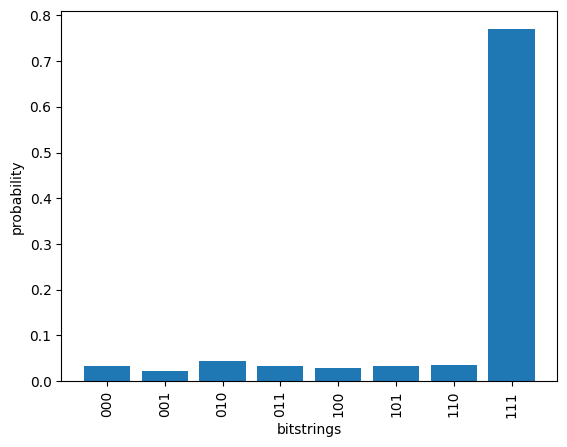

In [7]:
# Select item to find. Let's start with '111' for now
item = "111"

# get Grover circuit
circ = grover(item)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)

__DISCUSSION__: We observe a strong peak around the target solution given by the `111` bitstring, with all other bitstrings showing far smaller probabilities. 
Let us try one more item: 

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │
      ┌───┐       ┌───┐ ┌───┐ ┌───┐       ┌───┐ ┌───┐ ┌───┐ 
q0 : ─┤ H ├───────┤ U ├─┤ H ├─┤ X ├───────┤ U ├─┤ X ├─┤ H ├─
      └───┘       └─┬─┘ └───┘ └───┘       └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └─┬─┘ └───┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q2 : ─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │
Status: COMPLETED
measurement_counts: Counter({'100': 781, '001': 39, '110': 38, '000': 32, '101': 31, '111': 30, '011': 25, '010': 24})


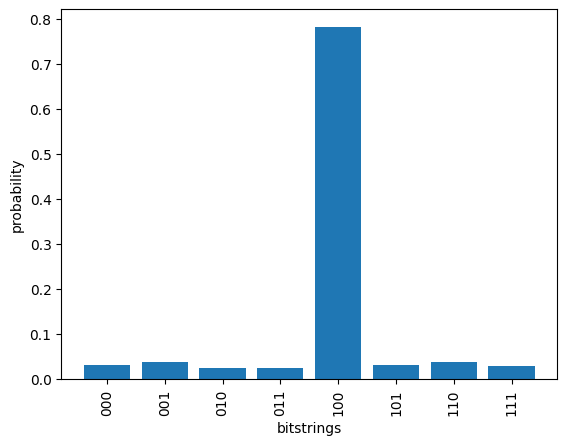

In [8]:
# Select item to find. Let's start with '111' for now
item = "100"

# get Grover circuit
circ = grover(item)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)

__DISCUSSION__: By repeating steps 2 (oracle) and 3 (amplification), we can further magnify the amplitude of the target item, thus maximizing the single-shot probability of identifying the right answer. This repetition is demonstrated below.

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │ 10  │ 11  │ 12  │ 13  │ 14  │ 15  │ 16  │
      ┌───┐       ┌───┐ ┌───┐ ┌───┐       ┌───┐ ┌───┐ ┌───┐       ┌───┐ ┌───┐ ┌───┐       ┌───┐ ┌───┐ ┌───┐ 
q0 : ─┤ H ├───────┤ U ├─┤ H ├─┤ X ├───────┤ U ├─┤ X ├─┤ H ├───────┤ U ├─┤ H ├─┤ X ├───────┤ U ├─┤ X ├─┤ H ├─
      └───┘       └─┬─┘ └───┘ └───┘       └─┬─┘ └───┘ └───┘       └─┬─┘ └───┘ └───┘       └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └─┬─┘ └───┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q2 : ─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └

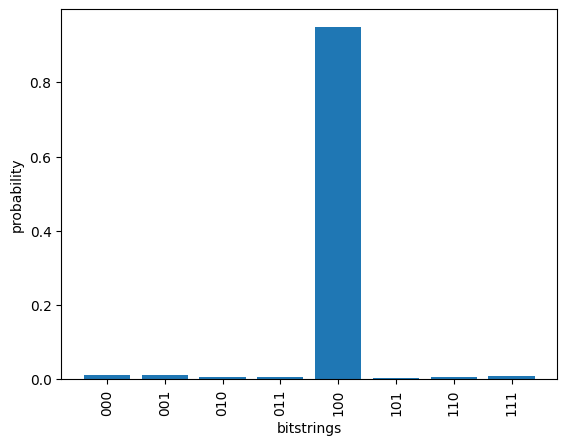

In [9]:
# Select item to find
item = "100"

# get Grover circuit
circ = grover(item, n_reps=2)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)

__DISCUSSION__: We observed how repeated application of the Grover operator has amplified the occurrence of the desired bitstring, while further suppressing wrong answers to our search problem. We get the correct result with high probability.  

## Device: IQM Garnet
Now, let's experiment this scheme on quantum hardware, by submitting our circuit to IQM Garnet. To achieve this check, we first need to express the CCZ gate in terms of the supported gates of IQM. In doing so, we build a custom gate that can be registered as a subroutine and then used as if it were any other supported quantum gate within our SDK. 

<div class="alert alert-block alert-warning">
    <b>Caution:</b> This section will create a QPU task which will incur a usage fee of about $2 to your AWS account. 
    You can view <a href="https://aws.amazon.com/braket/pricing/" target="_blank">this page</a> for more details on the usage fee.
    We also recommend monitoring the 
    <a href="https://console.aws.amazon.com/billing/home" target="_blank">Billing & Cost Management Dashboard</a> 
    on the AWS console.
</div>



In [10]:
# Set up a QPU device
device = AwsDevice(Devices.IQM.Garnet)
# get device name
device_name = device.name
# show the properties of the device
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()["action"]["braket.ir.openqasm.program"][
    "supportedOperations"
]
# Note: This field also exists for other devices like the QPUs
print(f"Quantum Gates supported by {device_name}:\n {device_operations}")

Quantum Gates supported by Garnet:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'swap', 'iswap', 'pswap', 'ecr', 'cy', 'cz', 'xy', 'xx', 'yy', 'zz', 'h', 'i', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 't', 'ti', 'v', 'vi', 'x', 'y', 'z', 'prx']


For the 𝑁=8 Grover demonstration with three qubits shown in Figgatt et al. (2017), we need to implement the Controlled-Controlled-Z ```CCZ``` gate that is not natively provided on the IQM device. We will construct this gate using native gates only such as ```CNOT``` and ```T```. Apart from our implementation, other alternative options are available (see [1] and references therein). 

In [11]:
@circuit.subroutine(register=True)
def CCNot(controls=[0, 1], target=2):
    """Build CCNOT from H, CNOT, T, Ti"""
    cQb1, cQb2 = controls
    circ = (
        Circuit()
        .h(target)
        .cnot(cQb2, target)
        .ti(target)
        .cnot(cQb1, target)
        .t(target)
        .cnot(cQb2, target)
        .ti(target)
        .cnot(cQb1, target)
        .t(target)
        .h(target)
        .t(cQb2)
        .cnot(cQb1, cQb2)
        .t(cQb1)
        .ti(cQb2)
        .cnot(cQb1, cQb2)
    )

    return circ


def CCZ(controls=[0, 1], target=2):
    """Build CCZ from H and CCNOT"""
    circ = Circuit().h(target).CCNot(controls, target).h(target)
    return circ


ccz_custom = CCZ()

Following are oracles defined based on target items:

In [12]:
# Four possible items and their corresponding oracles
oracle_qpu = {
    "000": Circuit().x([0, 1, 2]).add(ccz_custom).x([0, 1, 2]),
    "001": Circuit().x([0, 1]).add(ccz_custom).x([0, 1]),
    "010": Circuit().x([0, 2]).add(ccz_custom).x([0, 2]),
    "011": Circuit().x([0]).add(ccz_custom).x([0]),
    "100": Circuit().x([1, 2]).add(ccz_custom).x([1, 2]),
    "101": Circuit().x([1]).add(ccz_custom).x([1]),
    "110": Circuit().x([2]).add(ccz_custom).x([2]),
    "111": Circuit().add(ccz_custom),
}

In [13]:
# Select some example item to find
item = "111"

Same as with the classical simulator, we first initialize the qubits by applying the Hadamard gate ```H``` to every qubit.

In [14]:
# Initialize with superposition
circ = Circuit()
circ.h(np.arange(3))
print(circ)

T  : │  0  │
      ┌───┐ 
q0 : ─┤ H ├─
      └───┘ 
      ┌───┐ 
q1 : ─┤ H ├─
      └───┘ 
      ┌───┐ 
q2 : ─┤ H ├─
      └───┘ 
T  : │  0  │


Next, we apply the phase oracle corresponding to our target item.


In [15]:
# Construct phase oracle
circ.add_circuit(oracle_qpu[item])
print(circ)

T  : │  0  │  1  │  2  │  3  │  4   │  5  │  6  │  7  │  8   │  9  │ 10  │  11  │ 12  │
      ┌───┐                                                               ┌───┐        
q0 : ─┤ H ├────────────────────────────●────────────────────────●─────●───┤ T ├────●───
      └───┘                            │                        │     │   └───┘    │   
      ┌───┐                            │               ┌───┐    │   ┌─┴─┐ ┌────┐ ┌─┴─┐ 
q1 : ─┤ H ├───────────────●────────────┼───────────●───┤ T ├────┼───┤ X ├─┤ Ti ├─┤ X ├─
      └───┘               │            │           │   └───┘    │   └───┘ └────┘ └───┘ 
      ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌────┐ ┌─┴─┐ ┌───┐ ┌─┴─┐ ┌────┐ ┌─┴─┐ ┌───┐ ┌───┐  ┌───┐ 
q2 : ─┤ H ├─┤ H ├─┤ H ├─┤ X ├─┤ Ti ├─┤ X ├─┤ T ├─┤ X ├─┤ Ti ├─┤ X ├─┤ T ├─┤ H ├──┤ H ├─
      └───┘ └───┘ └───┘ └───┘ └────┘ └───┘ └───┘ └───┘ └────┘ └───┘ └───┘ └───┘  └───┘ 
T  : │  0  │  1  │  2  │  3  │  4   │  5  │  6  │  7  │  8   │  9  │ 10  │  11  │ 12  │


To complete the circuit, we define the diffusion operator, whose job is to magnify the amplitude difference created by the oracle.

In [16]:
# Amplification
circ.h(np.arange(3))
circ.add_circuit(oracle_qpu["000"])
circ.h(np.arange(3))
print(circ)

T  : │  0  │  1  │  2  │  3  │  4   │  5  │  6  │  7  │  8   │  9  │ 10  │  11  │ 12  │ 13  │ 14  │ 15  │ 16  │ 17  │  18  │ 19  │ 20  │ 21  │  22  │ 23  │ 24  │  25  │ 26  │ 27  │ 28  │
      ┌───┐                                                               ┌───┐        ┌───┐ ┌───┐                                                               ┌───┐        ┌───┐ ┌───┐ 
q0 : ─┤ H ├────────────────────────────●────────────────────────●─────●───┤ T ├────●───┤ H ├─┤ X ├────────────────────────────●────────────────────────●─────●───┤ T ├────●───┤ X ├─┤ H ├─
      └───┘                            │                        │     │   └───┘    │   └───┘ └───┘                            │                        │     │   └───┘    │   └───┘ └───┘ 
      ┌───┐                            │               ┌───┐    │   ┌─┴─┐ ┌────┐ ┌─┴─┐ ┌───┐ ┌───┐                            │               ┌───┐    │   ┌─┴─┐ ┌────┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q1 : ─┤ H ├───────────────●────────────┼───────────●───┤ T ├────┼

This circuit could potentially be optimized, as detailed in Ref.[1], but we will use this version for simplicity. 

In the final step, we retrieve the probabilistic counts for our target item. 
To this end, we submit our circuit to IQM Garnet, by setting the device as ```AwsDevice(Devices.IQM.Garnet)```. 

This quantum task may not be executed immediately as it enters a queue for this machine. 
Should we need to interrupt our kernel to work on something else, we can always recover our results using the unique ID of this quantum task, as shown in the following lines. 

<div class="alert alert-block alert-warning">
    <b>Caution:</b> Running the following cell will create a QPU task which will incur a usage fee of about $2 to your AWS account. 
    You can view <a href="https://aws.amazon.com/braket/pricing/" target="_blank">this page</a> for more details on the usage fee.
    We also recommend monitoring the 
    <a href="https://console.aws.amazon.com/billing/home" target="_blank">Billing & Cost Management Dashboard</a> 
    on the AWS console.
</div>


In [20]:
# set up device
qpu = AwsDevice(Devices.IQM.Garnet)

# run circuit
qpu_task = qpu.run(circ, shots=1000)

# get id and status of submitted quantum task
qpu_task_id = qpu_task.id
qpu_task_status = qpu_task.state()
# print('ID of task:', qpu_task_id)
print("Status of task:", qpu_task_status)

Status of task: QUEUED


In [18]:
# recover quantum task
task_load = AwsQuantumTask(arn=qpu_task_id)

# print status
status = task_load.state()
print("Status of (reconstructed) quantum task:", status)

# wait for hybrid job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == "COMPLETED":
    # get results
    results = task_load.result()

    # get all metadata of submitted quantum task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata["shots"]
    machine = metadata["deviceArn"]
    # print example metadata
    print(f"{shots} shots taken on machine {machine}.")

    # get measurement counts
    counts = results.measurement_counts
    print("Measurement counts:", counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig("iqm.png", dpi=700)
elif status in ["FAILED", "CANCELLED"]:
    # print terminal message
    print("Your quantum task is in terminal status, but has not completed.")

else:
    # print current status
    print("Your quantum task is still being processed and has not been finalized yet.")

Status of (reconstructed) quantum task: QUEUED
Your quantum task is still being processed and has not been finalized yet.


The output looks relatively noisy due to decoherence and gate errors in this relatively long gate sequence. However, we can still observe a dominant peak for the target item. 

In summary, we have shown how to implement Grover's search algorithm on a classical simulator, as well as on IQM Garnet, using simple modular building blocks. We have also demonstrated how to build custom gates outside of the basic gate set provided by the SDK, and how to register these as subroutines that can be used as if they were any other pre-defined quantum gate. 

---
# References <a name="ref"></a>

[1] C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, doi:10.1038/s41467-017-01904-7, arXiv:1703.10535.

[2] Nielsen, Michael A., Chuang, Isaac L. (2010). Quantum Computation and Quantum Information (2nd ed.). Cambridge: Cambridge University Press.

In [19]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).",
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD",
)

Quantum Task Summary
{<_IQM.Garnet: 'arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet'>: {'shots': 1000, 'tasks': {'QUEUED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 1.75 USD
